# Latent Diffusion Model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import pandas as pd
import torch
import seaborn as sns
import tqdm
import PIL.Image

In [2]:
!pip install accelerate
!pip install transformers gradio scipy ftfy "ipywidgets>=7,<8" datasets "diffusers==0.5.1"
from diffusers import DiffusionPipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 1.3 MB/s eta 0:00:0

## HuggingFace Stable Diffusion Model on CelebaHQ-256

In [25]:
model_id = "CompVis/ldm-celebahq-256"

pipeline = DiffusionPipeline.from_pretrained(model_id)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
run = pipeline(num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

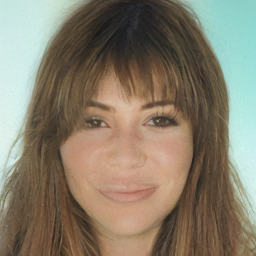

In [ ]:
img = run["sample"]
img[0]

### Cool, working. But this was very slow. Let's see if we can move to gpu / speed this up.

Following the tutorial, I'm also going to specify the models moving forward so inference steps are more clear.

In [3]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device

'cpu'

In [4]:
from diffusers import UNet2DModel, DDIMScheduler, VQModel

unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")

unet.to(torch_device)
vqvae.to(torch_device)

print("Good")

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Good


In [28]:
seed = 3
generator = torch.manual_seed(seed)
noise = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


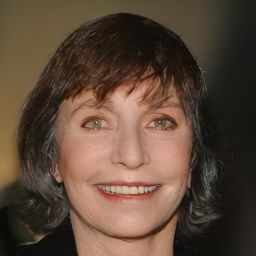

In [ ]:
scheduler.set_timesteps(num_inference_steps=200)

image = noise
for t in tqdm.tqdm(scheduler.timesteps):
    # predict noise residual of previous image
    with torch.no_grad():
        residual = unet(image, t)["sample"]

    # compute previous image x_t according to DDIM formula
    prev_image = scheduler.step(residual, t, image, eta=0.0)["prev_sample"]

    # x_t-1 -> x_t
    image = prev_image

# decode image with vae
with torch.no_grad():
    image = vqvae.decode(image)

# process image
image_processed = image.sample.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.clamp(0, 255).numpy().astype(np.uint8)
image_pil = PIL.Image.fromarray(image_processed[0])
image_pil

Make function so easier to generate images.

In [7]:
def generate_image_ldm(noise=None, skip_inference=False, num_inference_steps=50):
    if noise is None:
        noise = torch.randn(
            (1, unet.in_channels, unet.sample_size, unet.sample_size),
            generator=generator,
        ).to(torch_device)
    
    image = noise 

    if not skip_inference:
        scheduler.set_timesteps(num_inference_steps=num_inference_steps)

        for t in tqdm.tqdm(scheduler.timesteps):
            # predict noise residual of previous image
            with torch.no_grad():
                residual = unet(image, t)["sample"]

            # compute previous image x_t according to DDIM formula
            prev_image = scheduler.step(residual, t, image, eta=0.0)["prev_sample"]

            # x_t-1 -> x_t
            image = prev_image

    # decode image with vae
    with torch.no_grad():
        image = vqvae.decode(image)

    # process image
    image_processed = image.sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.clamp(0, 255).numpy().astype(np.uint8)
    return PIL.Image.fromarray(image_processed[0])

In [10]:
seed = 10
generator = torch.manual_seed(seed)

images = []
for i in range(9):
    images.append(generate_image_ldm())


100%|██████████| 50/50 [04:15<00:00,  5.12s/it]


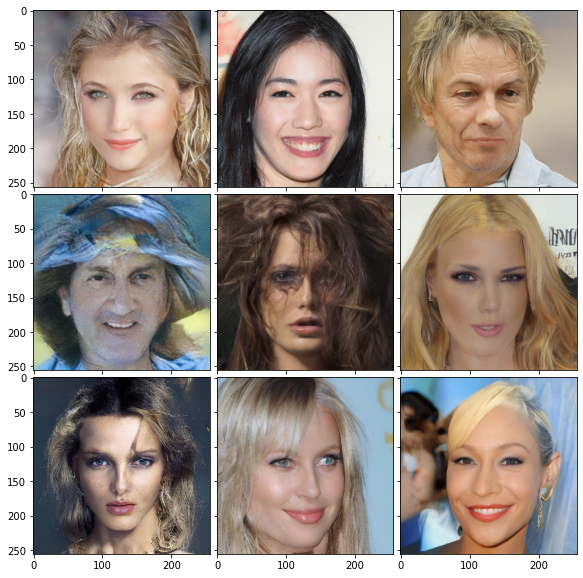

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

## What happens if we skip inference?

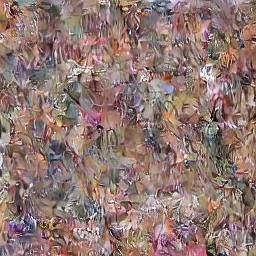

In [ ]:
generate_image_ldm(skip_inference = True)

Ok, don't do that...

100%|██████████| 100/100 [08:21<00:00,  5.02s/it]


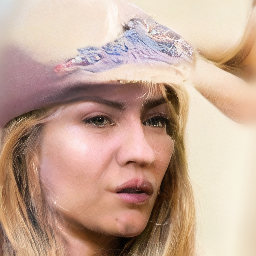

In [ ]:
generate_image_ldm(num_inference_steps=100)

## Latent Space Exploration

In [ ]:
noise_1 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_2 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

100%|██████████| 200/200 [00:16<00:00, 12.12it/s]


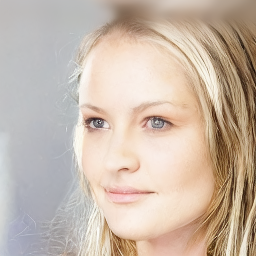

In [ ]:
generate_image_ldm(noise_1)

100%|██████████| 200/200 [00:16<00:00, 12.40it/s]


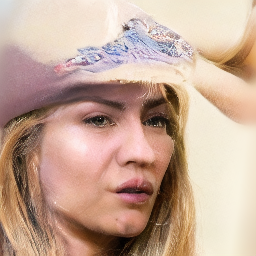

In [ ]:
generate_image_ldm(noise_2)

In [ ]:
steps = 10
vec = noise_2 - noise_1

step_size = 1/steps
noise = noise_1

images = []

images.append(generate_image_ldm(noise_1))

for i in range(steps):
    noise = noise + step_size*(vec)
    images.append(generate_image_ldm(noise))

100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


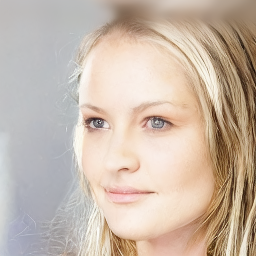

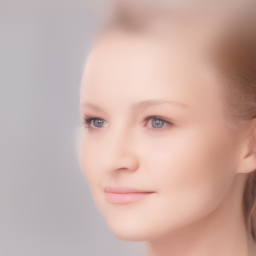

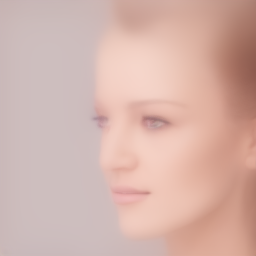

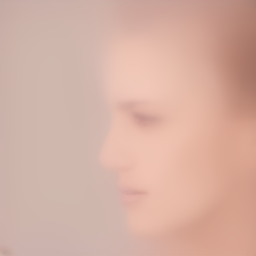

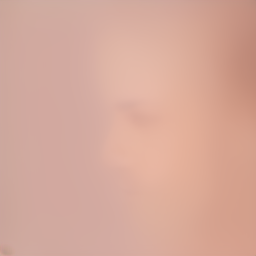

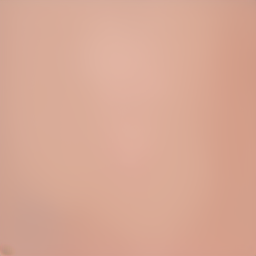

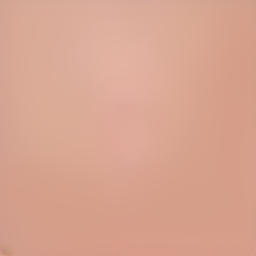

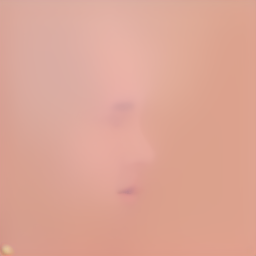

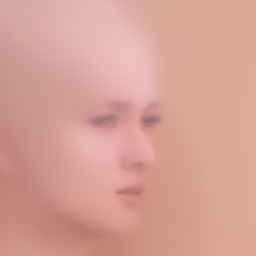

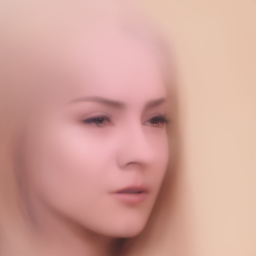

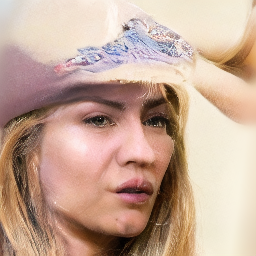

In [ ]:
for image in images:
    display(image)

Interesing... we are crossing a blurred path.

In [30]:
noise_1 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)
noise_1

tensor([[[[-0.4228,  0.0349, -0.6770,  ...,  0.1819,  0.4674, -1.4331],
          [-0.5398,  1.2848,  2.4076,  ..., -1.0008, -0.7217, -0.1237],
          [ 0.4514, -0.1825,  0.4078,  ...,  0.7649, -0.3159, -0.9071],
          ...,
          [-1.0207,  0.2839, -0.2256,  ..., -1.2171,  0.9566, -0.6754],
          [ 1.6513, -1.7075,  0.1144,  ...,  0.1102,  1.2936, -1.0060],
          [-1.4301, -0.2425, -0.0941,  ..., -0.4401, -0.6181, -1.6921]],

         [[-0.6106, -0.4181, -0.7590,  ...,  0.7621, -0.0464,  0.4164],
          [-0.0325, -1.3728, -0.1324,  ...,  2.3562,  0.1385,  0.5903],
          [ 0.7286, -0.2429, -0.9260,  ...,  0.0123,  1.8239, -0.0495],
          ...,
          [ 2.1073, -1.5650,  0.7758,  ...,  1.1374,  0.8237,  0.9857],
          [-0.0542, -1.2654, -0.7214,  ...,  0.7749,  0.8475, -1.8243],
          [-1.4646, -1.2014,  0.1286,  ...,  0.6752,  2.0231,  0.9597]],

         [[ 0.3314, -1.9873, -1.0442,  ..., -0.7319, -1.4401,  0.0206],
          [ 0.4761, -0.8136, -

## walk in diretion of noise vector so we don't cross 0

In [31]:
steps = 10

step_size = 1/steps
noise = noise_1

images = []

images.append(generate_image_ldm(noise_1))

for i in range(steps):
    noise = noise + step_size*(noise_1)
    images.append(generate_image_ldm(noise))

100%|██████████| 50/50 [04:11<00:00,  5.02s/it]


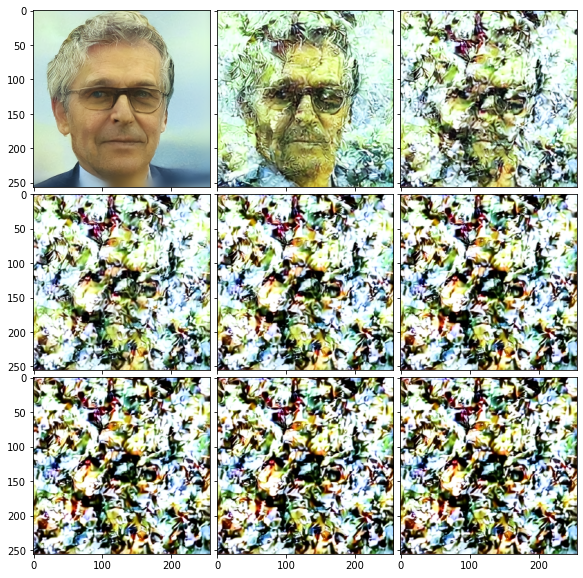

In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images[:-1]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

## Nope. Ok, let's confirm that the blurring process is universal and we didn't just choose two bad initial vectors.

In [33]:
noise_1 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_2 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_3 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_4 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

In [36]:
noise_1_5 = noise_1*.5 + .5*noise_2
noise_2_5 = noise_2*.5 + .5*noise_3
noise_3_5 = noise_3*.5 + .5*noise_4
noise_4_5 = noise_4*.5 + .5*noise_1


noise_middle = (noise_1 + noise_2 + noise_3 + noise_4 + noise_1_5 + noise_2_5 + noise_3_5 + noise_4_5)/8

noises = [noise_1, noise_1_5, noise_2, noise_2_5, noise_3, noise_3_5, noise_4, noise_4_5, noise_middle]

In [37]:
images = []

for i, noise in enumerate(noises):
    images.append(generate_image_ldm(noise))

100%|██████████| 50/50 [04:06<00:00,  4.93s/it]


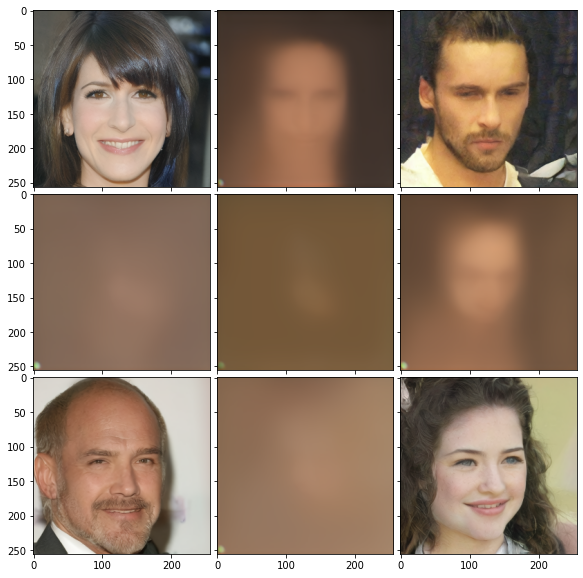

In [38]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
grid[0].imshow(images[0])
grid[1].imshow(images[1])
grid[2].imshow(images[2])
grid[3].imshow(images[7])
grid[4].imshow(images[8])
grid[5].imshow(images[3])
grid[6].imshow(images[6])
grid[7].imshow(images[5])
grid[8].imshow(images[4])


plt.show()

## Last Try let's Interpolate From the Decoder input

In [42]:
def encode_noise(noise=None, num_inference_steps=50):
    if noise is None:
        noise = torch.randn(
            (1, unet.in_channels, unet.sample_size, unet.sample_size),
            generator=generator,
        ).to(torch_device)
    
    image = noise 

    scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    for t in tqdm.tqdm(scheduler.timesteps):
        # predict noise residual of previous image
        with torch.no_grad():
            residual = unet(image, t)["sample"]

        # compute previous image x_t according to DDIM formula
        prev_image = scheduler.step(residual, t, image, eta=0.0)["prev_sample"]

        # x_t-1 -> x_t
        image = prev_image
    
    return image


def decode_noise(noise):
    # decode image with vae
    image = None
    with torch.no_grad():
        image = vqvae.decode(noise)

    # process image
    image_processed = image.sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.clamp(0, 255).numpy().astype(np.uint8)
    return PIL.Image.fromarray(image_processed[0])

In [41]:
noise_1 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_2 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_3 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

noise_4 = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

orig_noises = [noise_1, noise_2, noise_3, noise_4]

In [43]:
encoded_noises = []
for noise in orig_noises:
    encoded_noises.append(encode_noise(noise))

100%|██████████| 50/50 [04:06<00:00,  4.92s/it]


In [51]:
encoded_noise_interpolated = [encoded_noises[i]*.5 + encoded_noises[i + 1]*.5 for i in range(len(encoded_noises) - 1)]
encoded_noise_interpolated.append(encoded_noises[0]*.5 + encoded_noises[-1]*.5)
encoded_noise_interpolated.append(sum(encoded_noise_interpolated)/8)
print(len(encoded_noise_interpolated))


5


In [52]:
images = []
for noise in encoded_noises:
    images.append(decode_noise(noise))

for noise in encoded_noise_interpolated:
    images.append(decode_noise(noise))

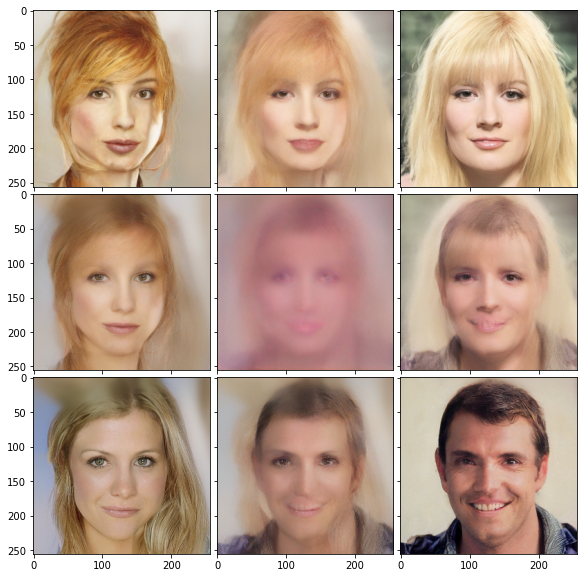

In [53]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
grid[0].imshow(images[0])
grid[2].imshow(images[1])
grid[8].imshow(images[2])
grid[6].imshow(images[3])

grid[1].imshow(images[4])
grid[5].imshow(images[5])
grid[7].imshow(images[6])
grid[3].imshow(images[7])
grid[4].imshow(images[8])

plt.show()